In [2]:
import numpy as np
import matplotlib.pyplot as plt
try:
    import cupy as cp
    print("CuPy available - Using GPU acceleration")
    xp = cp
except ImportError:
    print("CuPy not available - Using CPU (NumPy)")
    xp = np

CuPy available - Using GPU acceleration


In [45]:
class NeuralNetwork:
    def __init__(self, layer_sizes, use_gpu=False, activation_method='relu'):
        self.weights = []
        self.biases = []
        self.layer_sizes = layer_sizes
        self.xp = xp if use_gpu else np
        self.activation_method = activation_method

        for i in range((len(self.layer_sizes)) - 1):
            if activation_method == 'relu':
                scale = self.xp.sqrt(2.0 / self.layer_sizes[i])
            elif activation_method == 'sigmoid':
                scale = self.xp.sqrt(1.0 / self.layer_sizes[i])
            w = self.xp.random.randn(self.layer_sizes[i], layer_sizes[i + 1]) * scale
            self.weights.append(w)
            b = self.xp.zeros((1, self.layer_sizes[i + 1]))
            self.biases.append(b)

            print(f"    Created weights from layer {i} to {i + 1} with shape: {w.shape}")
            print(f"    Created biases for layer {i + 1} with shape: {b.shape}")
    
    def sigmoid(self, x):
        return 1 / (1 + self.xp.exp(-self.xp.clip(x, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def relu(self, x):
        return self.xp.maximum(0, x)
    
    def relu_derivative(self, X):
        return (X > 0).astype(float)
    
    def forward(self, X):
        """Forward propagation""" 
        activation = X
        for i in range(len(self.weights)):
            z = activation @ self.weights[i] + self.biases[i]
            activation = self.sigmoid(z)
        return activation
    
    def forward_with_activation(self, X, activation_method='relu'):
        """forward pass with relu for hidden layers, sigmoid for output"""
        activation = X
        activations = [X]

        #Hidden layers: using relu
        for i in range(len(self.weights) - 1):
            z = activation @ self.weights[i] + self.biases[i]
            
            if activation_method == 'relu':
                activation = self.relu(z)
            elif activation_method == 'sigmoid':
                activation = self.sigmoid(z)
            else:
                raise ValueError(f"Unknown activation method {activation_method}")
            activations.append(activation)
        
        #Output layer always uses sigmoid for classification
        z = activation @ self.weights[-1] + self.biases[-1]
        activation = self.sigmoid(z)
        activations.append(activation)

        return activation, activations

    def backward_with_activation(self, activations, delta, lr=0.1, activation_method='relu'):
        m = activations[0].shape[0]
        
        for i in range(len(self.weights) - 1, -1, -1):
            dw = activations[i].T @ delta / m
            db = self.xp.sum(delta, axis=0, keepdims=True) / m

            #Update parameters
            self.weights[i] = self.weights[i] - lr * dw
            self.biases[i] = self.biases[i] - lr * db

            if i > 0:
                if activation_method == 'relu':
                    delta = (delta @ self.weights[i].T) * self.relu_derivative(activations[i])
                elif activation_method == 'sigmoid':
                    delta = (delta @ self.weights[i].T) * self.sigmoid_derivative(activations[i])
    
    def predict(self, X, activation_method='relu'):
        """Make prediction"""
        if self.xp != np:
            X = self.xp.asarray(X)
        output, _ = self.forward_with_activation(X, activation_method=activation_method)
        if self.xp != np:
            output = self.xp.asnumpy(output)
        return output
    
    def train(self, X, y, epochs=100, lr=0.1, batch_size=None, activation_method='relu', verbose=True):
        if self.xp != np:
            X = self.xp.asarray(X)
            y = self.xp.asarray(y)

        losses = []
        n_samples = X.shape[0]

        use_minibatch = batch_size is not None and batch_size < n_samples
        n_batches = n_samples // batch_size if use_minibatch else 1

        for epoch in range(epochs):
            epoch_loss = 0

            if use_minibatch:
                #Shuffle data
                indices = self.xp.random.permutation(n_samples)
                X_shuffled = X[indices]
                y_shuffled = y[indices]
            else:
                X_shuffled = X
                y_shuffled = y

            for i in range(n_batches):
                if use_minibatch: 
                    start = i * batch_size
                    end = start + batch_size
                    X_batch = X_shuffled[start:end]
                    y_batch = y_shuffled[start:end]
                else:
                    X_batch = X_shuffled
                    y_batch = y_shuffled

                #Forward pass
                output, activations = self.forward_with_activation(X_batch, activation_method=activation_method)

                #Compute loss
                batch_loss = float(self.xp.mean((output - y_batch) ** 2))
                epoch_loss += batch_loss

                #Backward loss
                delta = output - y_batch
                self.backward_with_activation(activations, delta, lr, activation_method=activation_method)

            avg_loss = epoch_loss / n_batches
            losses.append(avg_loss)
            
            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")
    
        return losses


nn = NeuralNetwork(layer_sizes=[2, 3, 1])
print("\n--- Inspecting Weights ---")
for i, w in enumerate(nn.weights):
    print(f"Weights for connection {i}: \n{w}")

print("\n--- Inspecting Biases ---")
for i, b in enumerate(nn.biases):
    print(f"Biases for layer {i + 1}: \n{b}")
        

    Created weights from layer 0 to 1 with shape: (2, 3)
    Created biases for layer 1 with shape: (1, 3)
    Created weights from layer 1 to 2 with shape: (3, 1)
    Created biases for layer 2 with shape: (1, 1)

--- Inspecting Weights ---
Weights for connection 0: 
[[-0.07049857  0.26069659 -1.89437657]
 [ 1.27518189  0.09194801 -1.08696119]]
Weights for connection 1: 
[[ 0.80039604]
 [-2.33162977]
 [-0.86238894]]

--- Inspecting Biases ---
Biases for layer 1: 
[[0. 0. 0.]]
Biases for layer 2: 
[[0.]]


In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
iris = load_iris()
X = iris.data
y = iris.target
len(y)

150

In [6]:
y_onehot = np.zeros((len(y), 3))
for i in range(len(y)):
    y_onehot[i, y[i]] = 1
print(f"X shape: {X.shape}")  # (150, 4)
print(f"y shape: {y_onehot.shape}")  # (150, 3)

X shape: (150, 4)
y shape: (150, 3)


In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (120, 4)
Test set: (30, 4)


In [8]:
print(f"=== Creating Neural Network ===")
nn = NeuralNetwork(layer_sizes=[4, 8, 3])

print(f"=== Training ===")
losses = nn.train(X_train, y_train, epochs=2000, lr=0.1, batch_size=32, verbose=True)

=== Creating Neural Network ===
    Created weights from layer 0 to 1 with shape: (4, 8)
    Created biases for layer 1 with shape: (1, 8)
    Created weights from layer 1 to 2 with shape: (8, 3)
    Created biases for layer 2 with shape: (1, 3)
=== Training ===
Epoch 0/2000, Loss: 0.214979
Epoch 10/2000, Loss: 0.113346
Epoch 20/2000, Loss: 0.097782
Epoch 30/2000, Loss: 0.080996
Epoch 40/2000, Loss: 0.070840
Epoch 50/2000, Loss: 0.062697
Epoch 60/2000, Loss: 0.058805
Epoch 70/2000, Loss: 0.049263
Epoch 80/2000, Loss: 0.048324
Epoch 90/2000, Loss: 0.039862
Epoch 100/2000, Loss: 0.031374
Epoch 110/2000, Loss: 0.030014
Epoch 120/2000, Loss: 0.026171
Epoch 130/2000, Loss: 0.026378
Epoch 140/2000, Loss: 0.025272
Epoch 150/2000, Loss: 0.020539
Epoch 160/2000, Loss: 0.019360
Epoch 170/2000, Loss: 0.021946
Epoch 180/2000, Loss: 0.014762
Epoch 190/2000, Loss: 0.014028
Epoch 200/2000, Loss: 0.017285
Epoch 210/2000, Loss: 0.012996
Epoch 220/2000, Loss: 0.015583
Epoch 230/2000, Loss: 0.018571
Epoc

In [9]:
y_pred = nn.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = np.mean(y_pred_labels == y_test_labels) * 100
print(f"=== Results ===")
print(f"Test accuracy: {accuracy:.3f}%")

for i in range(5):
    print(f"True: {y_test_labels[i]}, Predict: {y_pred_labels[i]}, Probability: {y_pred[i]}")

=== Results ===
Test accuracy: 100.000%
True: 1, Predict: 1, Probability: [2.25011282e-04 9.99688175e-01 2.58099895e-04]
True: 0, Predict: 0, Probability: [9.99989330e-01 3.91512696e-04 8.98954194e-09]
True: 2, Predict: 2, Probability: [5.50466693e-15 2.53492044e-10 1.00000000e+00]
True: 1, Predict: 1, Probability: [3.45167988e-05 9.95343980e-01 3.78402916e-03]
True: 1, Predict: 1, Probability: [5.61783802e-06 9.97041004e-01 2.81763299e-03]


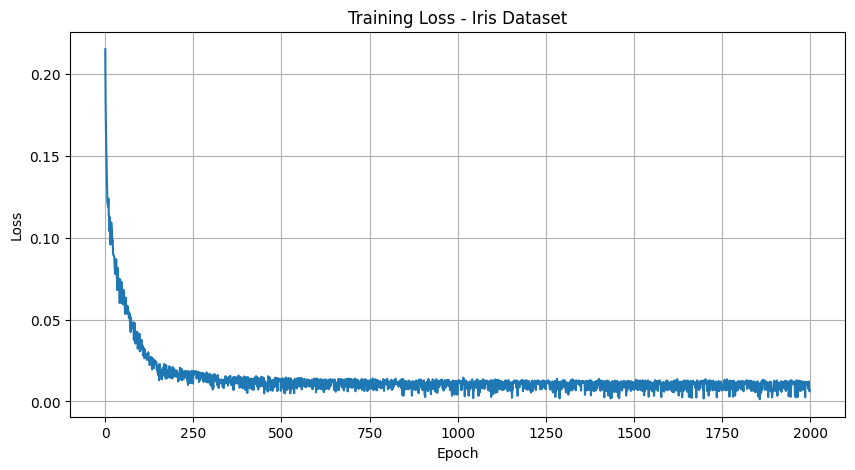

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss - Iris Dataset")
plt.grid(True)
plt.show()

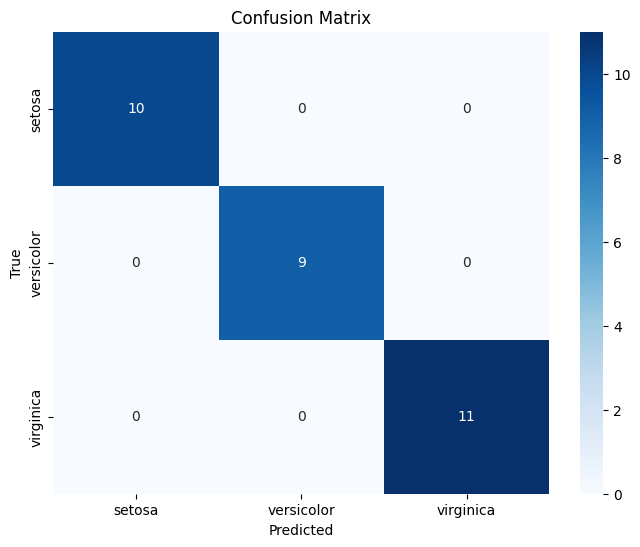

In [11]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=iris.target_names, 
            yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X_mnist = mnist.data.to_numpy()
y_mnist = mnist.target.to_numpy().astype(int)

print(f"X shape: {X_mnist.shape}")
print(f"y shape: {y_mnist.shape}")

X shape: (70000, 784)
y shape: (70000,)


In [13]:
#Normalize pixel values
X_mnist = X_mnist / 255.0

#Onehot encoding
y_onehot = np.zeros((len(y_mnist), 10))
for i in range(len(y_mnist)):
    y_onehot[i, y_mnist[i]] = 1

print(f"X range: [{X_mnist.min()}, {X_mnist.max()}]")
print(f"y_onehot shape: {y_onehot.shape}")

X range: [0.0, 1.0]
y_onehot shape: (70000, 10)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_onehot, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (56000, 784)
Test set: (14000, 784)


In [46]:
print("\n=== Creating Neural Network ===")
nn_mnist = NeuralNetwork(layer_sizes=[784, 128, 64, 10], use_gpu=True)
print("\n=== Training ===")
losses = nn_mnist.train(X_train, y_train, epochs=100, lr=0.005, verbose=True)


=== Creating Neural Network ===
    Created weights from layer 0 to 1 with shape: (784, 128)
    Created biases for layer 1 with shape: (1, 128)
    Created weights from layer 1 to 2 with shape: (128, 64)
    Created biases for layer 2 with shape: (1, 64)
    Created weights from layer 2 to 3 with shape: (64, 10)
    Created biases for layer 3 with shape: (1, 10)

=== Training ===
Epoch 0/100, Loss: 0.251171
Epoch 10/100, Loss: 0.181201
Epoch 20/100, Loss: 0.132423
Epoch 30/100, Loss: 0.106243
Epoch 40/100, Loss: 0.096502
Epoch 50/100, Loss: 0.092717
Epoch 60/100, Loss: 0.090763
Epoch 70/100, Loss: 0.089402
Epoch 80/100, Loss: 0.088238
Epoch 90/100, Loss: 0.087135
Epoch 99/100, Loss: 0.086150


In [47]:
y_pred = nn_mnist.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = np.mean(y_pred_labels == y_test_labels) * 100
print(f"Accuracy: {accuracy:.4f}%")

Accuracy: 35.6500%


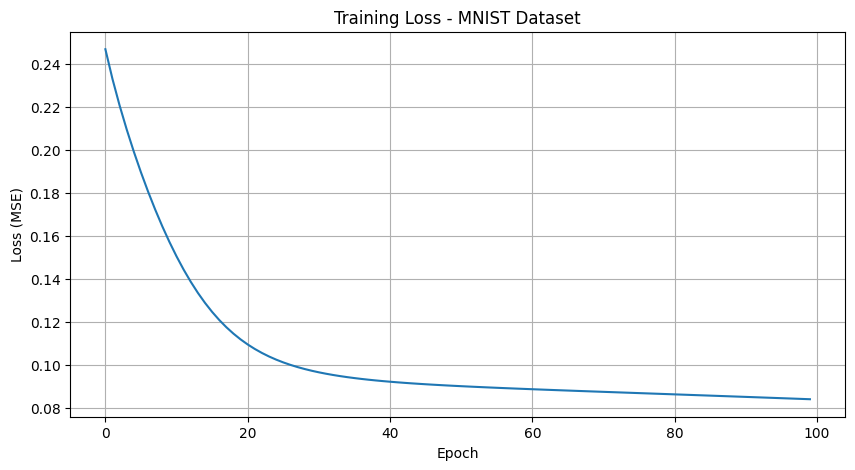

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss - MNIST Dataset')  
plt.grid(True)
plt.show()

In [51]:
print("\n=== Creating Neural Network ===")
nn_mnist_minibatch = NeuralNetwork(layer_sizes=[784, 128, 64, 10], use_gpu=True, activation_method='relu')
print("\n=== Training ===")
losses = nn_mnist_minibatch.train(X_train, y_train, epochs=100, batch_size=128, lr=0.005, activation_method='relu', verbose=True)


=== Creating Neural Network ===
    Created weights from layer 0 to 1 with shape: (784, 128)
    Created biases for layer 1 with shape: (1, 128)
    Created weights from layer 1 to 2 with shape: (128, 64)
    Created biases for layer 2 with shape: (1, 64)
    Created weights from layer 2 to 3 with shape: (64, 10)
    Created biases for layer 3 with shape: (1, 10)

=== Training ===
Epoch 0/100, Loss: 0.076415
Epoch 10/100, Loss: 0.014932
Epoch 20/100, Loss: 0.011212
Epoch 30/100, Loss: 0.009181
Epoch 40/100, Loss: 0.007815
Epoch 50/100, Loss: 0.006788
Epoch 60/100, Loss: 0.006011
Epoch 70/100, Loss: 0.005372
Epoch 80/100, Loss: 0.004861
Epoch 90/100, Loss: 0.004420
Epoch 99/100, Loss: 0.004093


nn_mnist_minibatch = NeuralNetwork(layer_sizes=[784, 128, 64, 10], use_gpu=True, activation_method='relu')
losses = nn_mnist_minibatch.train(X_train, y_train, epochs=100, batch_size=128, lr=0.005, activation_method='relu', verbose=True)
==> accuracy: 96.7857%

In [52]:
y_pred = nn_mnist_minibatch.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = np.mean(y_pred_labels == y_test_labels) * 100
print(f"Accuracy: {accuracy:.4f}%")

Accuracy: 96.7857%


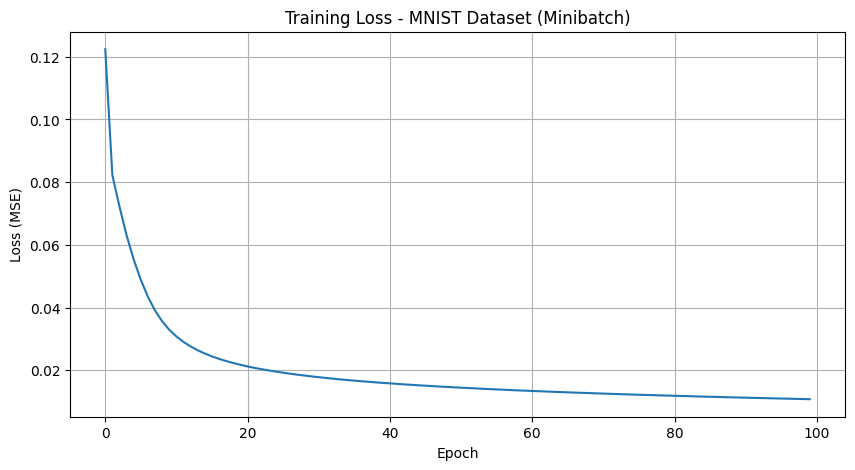

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss - MNIST Dataset (Minibatch)')
plt.grid(True)
plt.show()

In [ ]:

cm = confusion_matrix(y_test_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('ed Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.2f}%')
plt.show()

In [ ]:
print("\n=== Per-Digit Accuracy ===")
for digit in range(10):
    mask = y_test_labels == digit
    digit_acc = np.mean(y_pred_labels[mask] == digit) * 100
    print(f"Digit {digit}: {digit_acc:.2f}%")